# Initialization

In [629]:
ls

FIFA 2018 Statistics.csv
Shapley Value appx.ipynb
Untitled2.ipynb
algo.ipynb
company_bankruptcy_prediction.csv
hierarchical_shap_fed.ipynb
house-prices-advanced-regression-techniques/
party.py


In [1]:
cd Documents/UM/22_23/Project 2/code

/Users/leon/Documents/UM/22_23/Project 2/code


In [372]:
import csv
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import warnings

from collections import Counter
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Basic Model

In [3]:

shape = (100, 16)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input
#print(X)


In [4]:
reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_

(0.9993316174977624,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

In [136]:

def divisive_shap_approx(X, y, model, beta, gamma_n, gamma_d, num_partitions):
    if X.shape[1] > np.emath.logn(beta, n):
        partitions = []
        sum_gamma_n = 0
        sum_gamma_d = 0
        for _ in range(num_partitions):
            split_S = partition(X,y)
            partitions.append(split_S)
            sum_gamma_n += value(X, y, model)
            sum_gamma_d += sum([value(Xi, yi, model) for Xi, yi in split_S])
        gamma_n = gamma_n * (sum_gamma_n / num_partitions)
        gamma_d = gamma_d * (sum_gamma_d / num_partitions)
        return union([divisive_shap_approx(Xi,
                                           yi,
                                           model,
                                           beta,
                                           gamma_n,
                                           gamma_d,
                                           num_partitions) for Xi, yi in split_S])
    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)

def value(X, y, model):
    if X.size == 0:
        return 0
    else:
        reg = model.fit(X, y)
        return reg.score(X, y)


def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def shapley_true(X, y, model):
    """Returns true shapley value of each feature (numpy array)"""
    N = X.shape[1]
    shap = np.zeros(N)
    for i in range(N):
        other_features = set(range(N))
        other_features.remove(i)
        subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
        for subset in subsets:
            coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
            shap[i] += coeff*(value(X[:,list(subset) + [i]], y, model)-value(X[:, list(subset)], y, model))
    return np.array(shap)

def partition(X, y):
    """Returns list of tuples: [(X1, Y1), (X2, Y2), ...]"""
    #N = X.shape[1]
    #return [(X[:,:N//2], y), (X[:,N//2:], y)]

    split_results = []
    X_train, X_test = train_test_split(X.T, test_size=0.5, )#random_state=42)
    return [(X_train.T, y), (X_test.T, y)]

def union(S_split):
    """Returns the union of several sets (Xi, Yi, Shapi)"""
    X = S_split[0][0]
    y = S_split[0][1]
    shap = S_split[0][2]
    for Xi, _, shapi in S_split[1:]:
        X = np.concatenate((X, Xi), axis=1)
        shap = np.concatenate((shap, shapi))
    return (X, y, shap)


In [6]:
def main(X, y, model, beta, num_partitions = 1):
    X2, y2, shap = divisive_shap_approx(X, y, model, beta, 1, 1, num_partitions)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)

## Examples

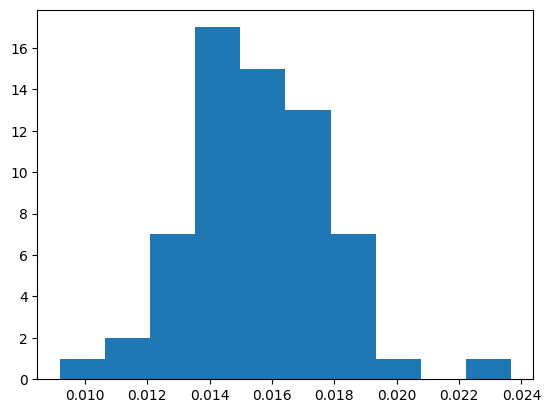

In [ ]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()


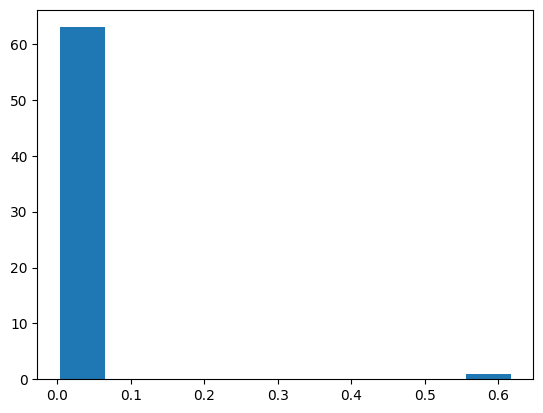

In [ ]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
X[:,0] = X[:,0]*10
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()

# K-means splitting algo

In [507]:
def main2(X, y, model, beta, k, num_loops = 1):
    X2, y2, shap = divisive_shap_approx_knn(X, y, model, beta, 1, 1, k, num_loops)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)
def divisive_shap_approx_knn(X, y, model, beta, gamma_n, gamma_d, k, num_loops):
    if X.shape[1] > max(np.emath.logn(beta, n), k):

        partitions = []
        sum_gamma_n = 0
        sum_gamma_d = 0
        for _ in range(num_loops):
            split_S = partition_cosine(X,y,k)
            partitions.append(split_S)
            sum_gamma_n += value(X, y, model)
            sum_gamma_d += sum([value(Xi, yi, model) for Xi, yi in split_S])
        gamma_n = gamma_n * (sum_gamma_n / num_loops)
        gamma_d = gamma_d * (sum_gamma_d / num_loops)
        return union([divisive_shap_approx_knn(Xi,
                                               yi,
                                               model,
                                               beta,
                                               gamma_n,
                                               gamma_d,
                                               k,
                                               num_loops) for Xi, yi in split_S])

    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)

def partition_knn(X,y,k):

    transposed_X = X.T

    kmeans = KMeans(
        init="random",
        n_clusters=k,
        n_init=10,
        max_iter=300,
        #random_state=42
    )
    kmeans.fit(transposed_X)
    labels = kmeans.labels_
    X = transposed_X.T
    partitions = []
    X = pd.DataFrame(X)
    for i in range(k):
        partitions.append((np.array(X.iloc[:,labels == i]),y))

    return partitions

def partition_cosine(X, y, k):

    X = X.T
    #similarities = cosine_similarity(X)

    # Initialize cluster assignments randomly
    #np.random.seed(42)
    labels = np.random.randint(low=0, high=k, size=len(X))

    # Iteratively update cluster assignments based on cosine similarity
    for _ in range(10):  # You can adjust the number of iterations as needed
        cluster_centers = []
        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                cluster_center = np.mean(cluster_points, axis=0)
                cluster_centers.append(cluster_center)
        cluster_centers = np.array(cluster_centers)

        # Assign each point to the nearest cluster center based on cosine similarity
        for i in range(len(X)):
            point = X[i]
            similarities_to_centers = cosine_similarity([point], cluster_centers)[0]
            new_label = np.argmax(similarities_to_centers)
            labels[i] = new_label

    partitions = []
    X = X.T
    X = pd.DataFrame(X)

    for i in range(k):
        partitions.append((np.array(X.iloc[:, labels == i]), y))

    return partitions

# FIFA Dataset

In [373]:
df = pd.read_csv('FIFA 2018 Statistics.csv')

# Select columns with dtype np.int64 or np.float64
#selected_columns = df.select_dtypes(include=[np.int64, np.int64]).columns

# Apply Min-Max scaling to the selected columns
#df[selected_columns] = MinMaxScaler().fit_transform(df[selected_columns])
#df = df.fillna(0)

y = (df['Man of the Match'] == "Yes")
y = [1 if label == True else 0 for label in y]
feature_names = [i for i in df.columns if df[i].dtype in [np.int64, np.int64]]
X = df[feature_names]


X_norm = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1)
X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,46,11,1,6,4,4,3,24,5,79,479,148,14,1,0,0,0
124,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,0
125,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,0
126,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,0


In [374]:
FIFA_cols = ['Goals',	'Ball Poss. %',	'Attempts', 'On-Target',	'Off-Target',	'Blocked',	'Corners',	'Offsides',	'Free Kicks',	'Saves',	'Pass Acc. %',	'Passes',	'Dist.',	'Fouls',	'Yellow',	'Yellow, Red',	'Red'	,'Goals in PSO']

In [ ]:
log_reg = LogisticRegression().fit(X_train, y_train)
test_predictions = log_reg.predict(X_test)
log_reg.score(X_test, y_test), reg.coef_

(0.71875,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

## SHAP library

     Actual  Predicted
0         1       0.92
1         0       0.03
2         0       0.02
3         1       0.89
4         0       0.07
..      ...        ...
123       0       0.28
124       1       0.84
125       0       0.15
126       1       0.79
127       0       0.37

[128 rows x 2 columns]
RMSE (Test): 0.17237994010324983
score:  0.881140625


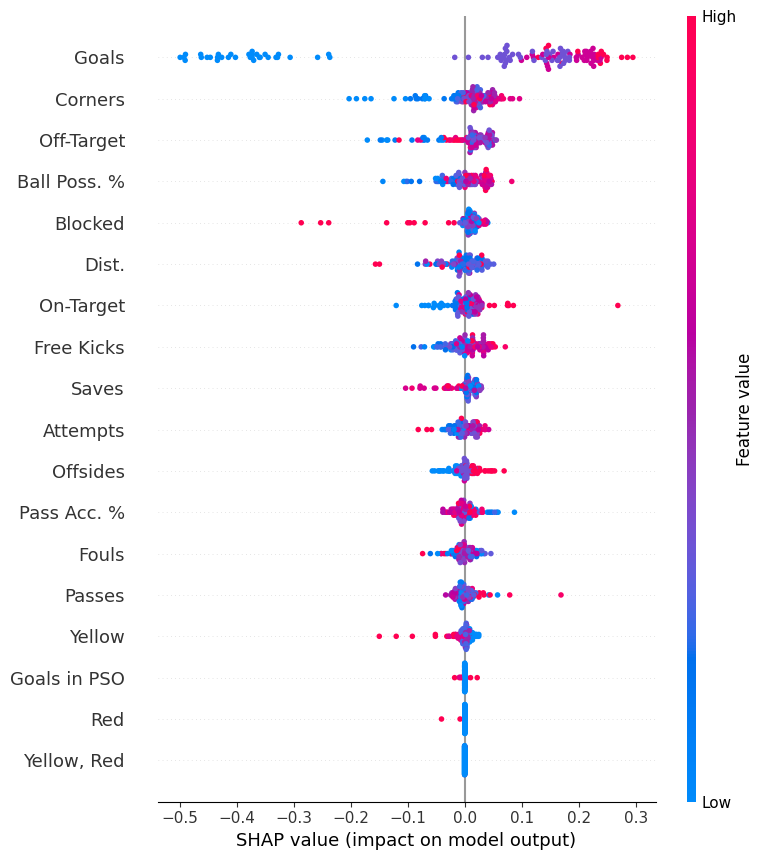

In [381]:


feature_names = FIFA_cols

X_train = X_norm
y_train = y
X_test = X_norm
y_test = y

# Align the training and test data to ensure the same columns are present
#X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='outer', axis=1, fill_value=0)

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Fit model
reg = LinearRegression()
reg = LogisticRegression()
reg = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg.predict(X_test)

# Example: Calculate root mean squared error (RMSE) on the test set
rmse_test = mean_squared_error(y_test, y_pred, squared=False)

# Convert y_test and y_pred to Pandas Series
y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')

# Concatenate actual and predicted values for display
results = pd.concat([y_test_series, y_pred_series], axis=1)
print(results)

print("RMSE (Test):", rmse_test)
print('score: ', reg.score(X_test, y_test))

# Create an explainer object using the trained model and training data
explainer = shap.Explainer(reg, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test, check_additivity=False)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


In [367]:

average_shap_values = np.abs(shap_values.values).mean(axis=0)
average_shap_values /= sum(average_shap_values)


In [ ]:
N = X.shape[1]
shap = np.zeros(N)
for i in tqdm(range(N)):
    other_features = set(range(N))
    other_features.remove(i)
    subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
    for subset in subsets:
        coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
        shap[i] += coeff*(value(X_norm[:,list(subset) + [i]], y, reg)-value(X_norm[:, list(subset)], y, reg))
true_shapley = np.array(shap)
print(true_shapley)

In [365]:
true_shapley = [0.16999648, 0.00351305, 0.01231289, 0.03640622, 0.0052994,  0.02015739, 0.01889732, 0.0034261,  0.00753081, 0.00282818, 0.00419999, 0.00374287, 0.00380925, 0.00176043, 0.01024351, 0.00525661, 0.01237468, 0.01605793]

In [ ]:
len(FIFA_cols)

17

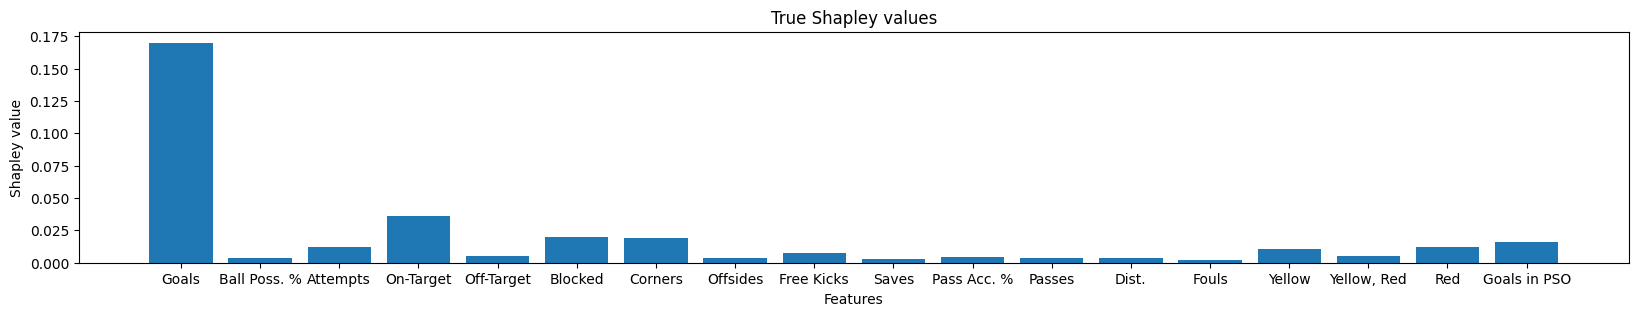

In [366]:
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(FIFA_cols, true_shapley)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('True Shapley values')
plt.show()


In [ ]:
cosine_sim = cosine_similarity([true_shapley], [arr1])[0][0]
print(cosine_sim)

0.8641209091349279


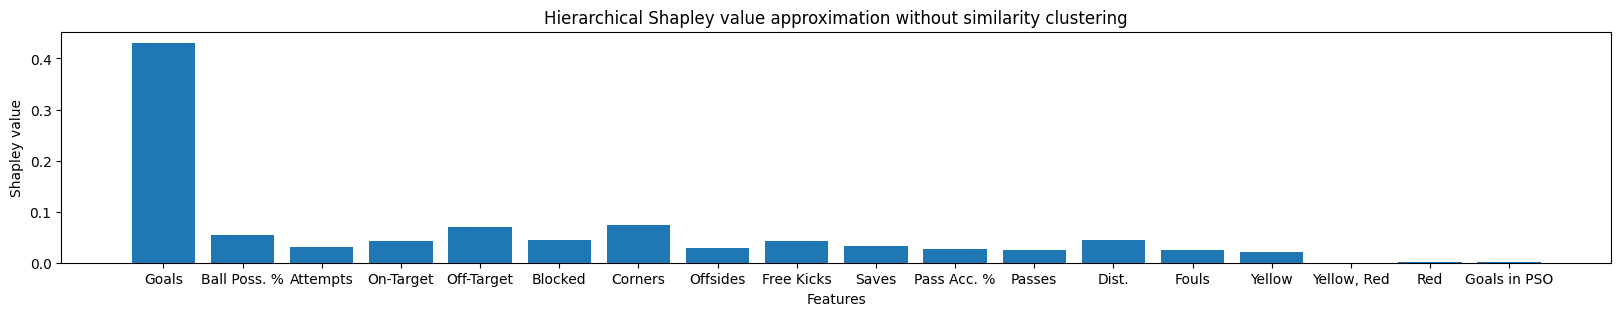

In [368]:
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(FIFA_cols, average_shap_values)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('SHAP library')
plt.show()


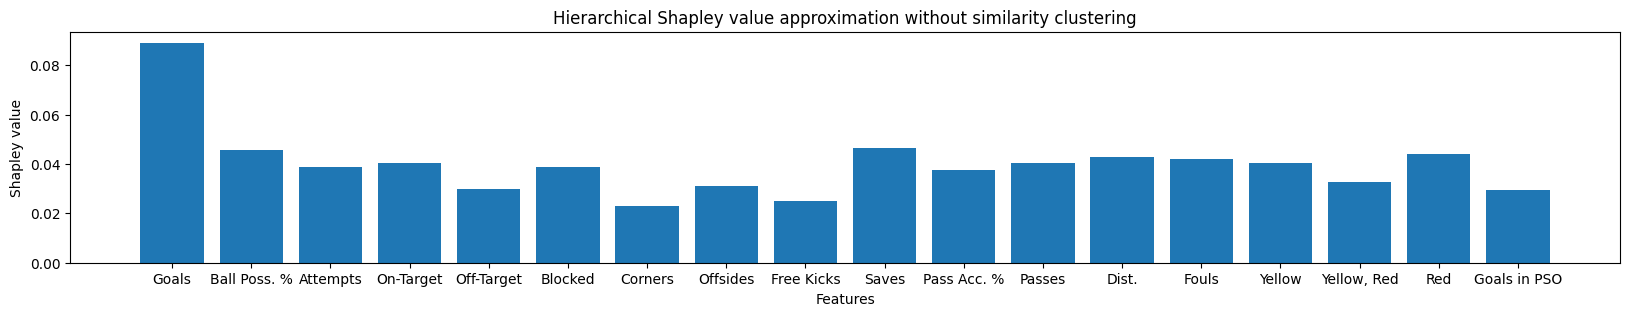

In [ ]:
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(FIFA_cols, shap)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation without similarity clustering')
plt.show()


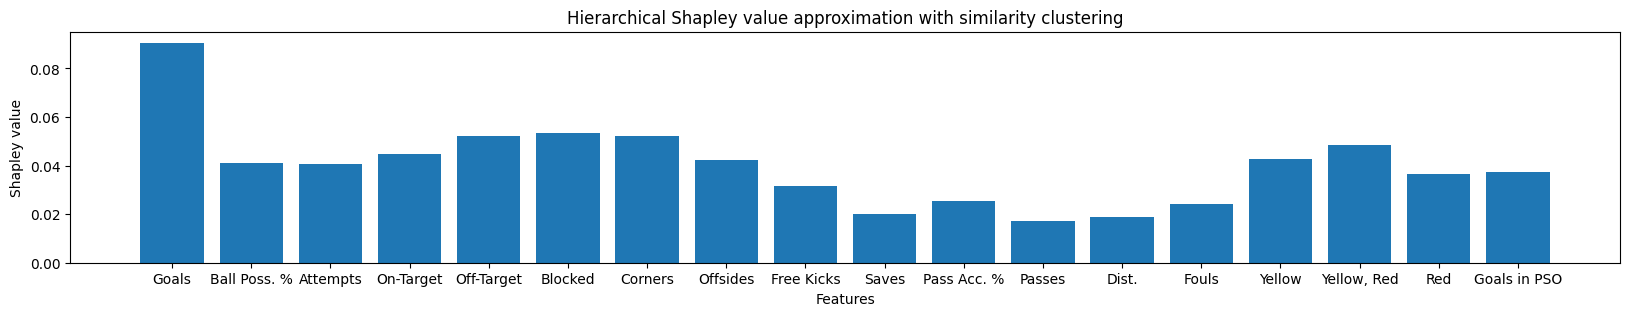

In [ ]:
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(FIFA_cols, shap_knn)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation with similarity clustering')
plt.show()


# Boston housing dataset

In [765]:
boston = load_boston()

X_boston = boston.data
y_boston = boston.target


X_boston_norm = MinMaxScaler().fit_transform(X_boston)
X_train, X_test, y_train, y_test = train_test_split(X_boston_norm, y_boston, random_state=42)


X_train = X_boston_norm
X_test = X_boston_norm
y_train = y_boston
y_test = y_boston

In [703]:
reg = LinearRegression().fit(X_train, y_train)

test_predictions = reg.predict(X_test)

# Print the correct and predicted labels side by side
#for true_label, predicted_label in zip(y_test, test_predictions):
#    print(f"True label: {true_label}, Predicted label: {predicted_label}")

reg.score(X_test, y_test), reg.coef_


(0.7406426641094095,
 array([ -9.60975755,   4.64204584,   0.56083933,   2.68673382,
         -8.63457306,  19.88368651,   0.06721501, -16.22666104,
          7.03913802,  -6.46332721,  -8.95582398,   3.69282735,
        -19.01724361]))

Now we calculate exact Shapley values to calculate Mean-Squared Error(MSE) and Root-Mean Squared Error(RMSE)


In [ ]:
N = X_boston.shape[1]
shap = np.zeros(N)
for i in tqdm(range(N)):
    other_features = set(range(N))
    other_features.remove(i)
    subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
    for subset in subsets:
        coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
        shap[i] += coeff*(value(X_boston_norm[:,list(subset) + [i]], y_boston, reg)-value(X_boston_norm[:, list(subset)], y_boston, reg))
true_shapley_boston = np.array(shap)
print(true_shapley_boston)

In [695]:
true_shapley_boston  = [0.02717564, 0.02481086, 0.03778189, 0.01584259, 0.03341462, 0.18708535,
 0.02203524, 0.03027707, 0.02362935, 0.03678939, 0.07852551, 0.0229129,
 0.20036224]

     Actual  Predicted
0      24.0     25.207
1      21.6     21.877
2      34.7     35.114
3      33.4     33.882
4      36.2     35.418
..      ...        ...
501    22.4     23.032
502    20.6     19.758
503    23.9     25.745
504    22.0     24.119
505    11.9     14.862

[506 rows x 2 columns]
RMSE (Test): 1.1948224238379226
score:  0.9830892190209453


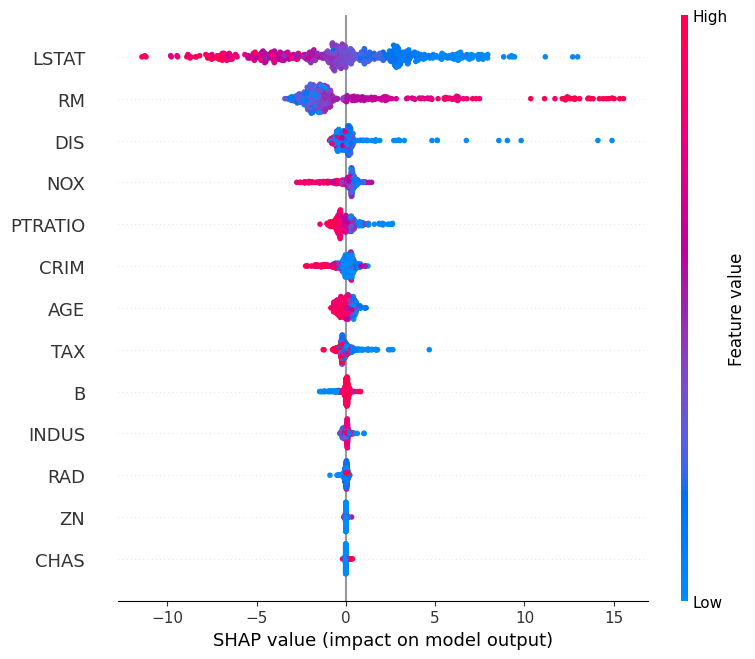

In [704]:


feature_names = boston.feature_names



# Fit model
reg = LinearRegression()
#reg = LogisticRegression()
#reg = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg.predict(X_test)

# Example: Calculate root mean squared error (RMSE) on the test set
rmse_test = mean_squared_error(y_test, y_pred, squared=False)

# Convert y_test and y_pred to Pandas Series
y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')

# Concatenate actual and predicted values for display
results = pd.concat([y_test_series, y_pred_series], axis=1)
print(results)

print("RMSE (Test):", rmse_test)
print('score: ', reg.score(X_test, y_test))

# Create an explainer object using the trained model and training data
explainer = shap.Explainer(reg, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test, check_additivity=False)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


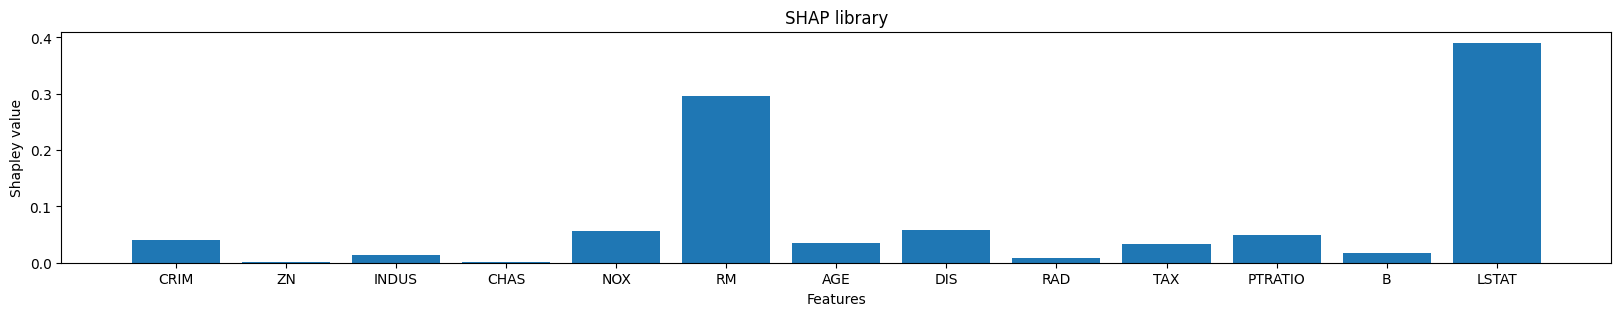

In [705]:

average_shap_values = np.abs(shap_values.values).mean(axis=0)
average_shap_values /= sum(average_shap_values)
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(feature_names, average_shap_values)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('SHAP library')
plt.show()


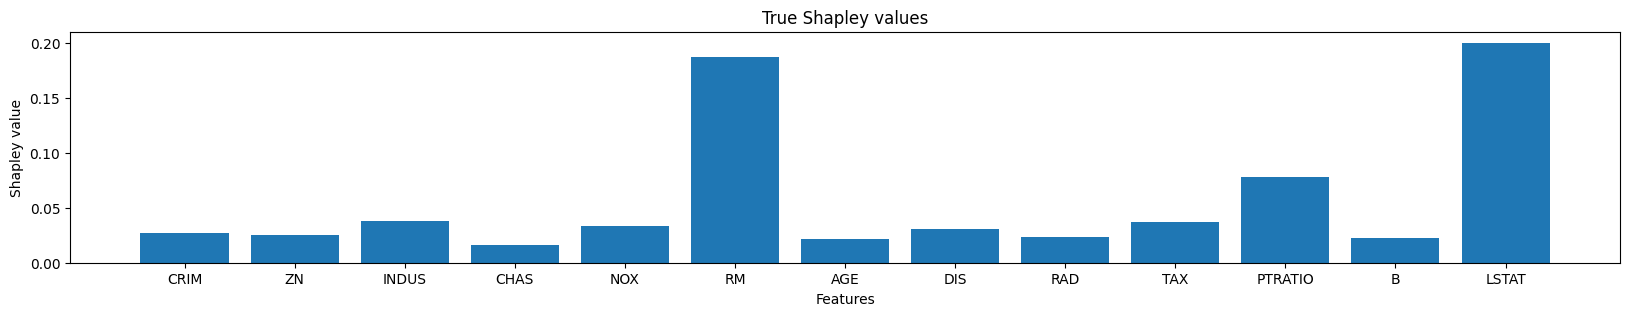

In [422]:


# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(boston.feature_names, true_shapley_boston)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('True Shapley values')
plt.show()


In [ ]:
n = X_train.shape[1]
X2, y2, shap = main(np.array(X_train), np.array(y_train), reg, n**(1/np.sqrt(n)), 1)
# Compute the RMSE
#print(shap)
mse = mean_squared_error(true_shapley_boston, shap)
#rmse = np.sqrt(mse)
print(mse)
#cosine_sim = cosine_similarity([true_shapley_boston], [shap])[0][0]
#print(cosine_sim)
#plt.plot(shap)


# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(boston.feature_names, shap)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation without similarity clustering')
plt.show()


In [775]:
%%time
column_permutation = []
for col in range(X_train.shape[1]):
    for col2 in range(X2.shape[1]):
        if np.array_equal(X_train[:, col], X2[:, col2]):
            column_permutation.append(col2)
            break


X2_reordered = X2[:, column_permutation]
shap_reordered = shap_knn[column_permutation]

CPU times: user 495 µs, sys: 1 µs, total: 496 µs
Wall time: 501 µs


In [776]:
column_permutation

[3, 10, 5, 0, 7, 9, 1, 11, 6, 8, 4, 12, 2]

0.0028081945579171053


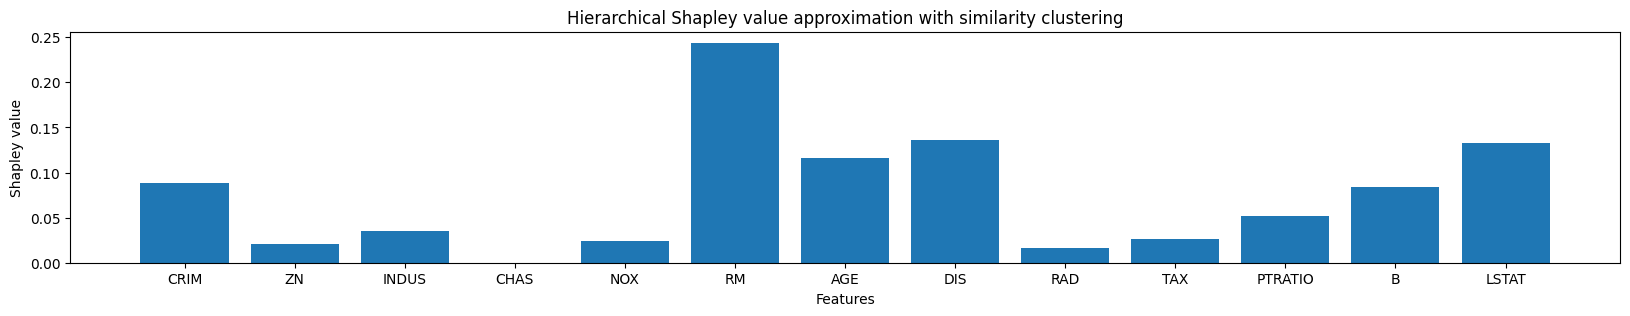

CPU times: user 328 ms, sys: 45.7 ms, total: 374 ms
Wall time: 180 ms


In [779]:
%%time
n = X_train.shape[1]
#X2, y2, shap_knn = main2(np.array(X_train), np.array(y_train), reg, n**(1/np.sqrt(n)),2, 1)
#print(shap_knn)
mse_knn = mean_squared_error(true_shapley_boston, shap_reordered)
rmse_knn = np.sqrt(mse_knn)
print(mse_knn)

cosine_sim = cosine_similarity([true_shapley_boston], [shap_reordered])[0][0]
#print(cosine_sim)
#plt.plot(shap_knn)

# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(boston.feature_names, shap_reordered)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation with similarity clustering')
plt.show()

0.009168385751309013


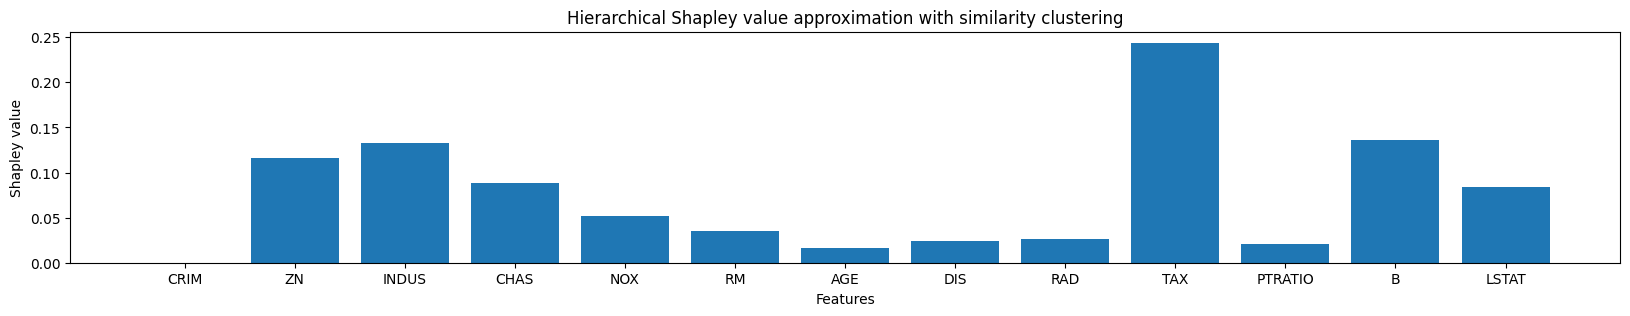

In [770]:

n = X_train.shape[1]
X2, y2, shap_knn = main2(np.array(X_train), np.array(y_train), reg, n**(1/np.sqrt(n)),2, 1)
#print(shap_knn)
mse_knn = mean_squared_error(true_shapley_boston, shap_knn)
rmse_knn = np.sqrt(mse_knn)
print(mse_knn)

cosine_sim = cosine_similarity([true_shapley_boston], [shap_knn])[0][0]
#print(cosine_sim)
#plt.plot(shap_knn)

# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(boston.feature_names, shap_knn)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation with similarity clustering')
plt.show()

# High Number of Features

        Actual  Predicted
0     0.241078   0.239442
1     0.203583   0.194602
2     0.261908   0.256684
3     0.145952   0.170594
4     0.298709   0.321917
...        ...        ...
1455  0.194556   0.194261
1456  0.243161   0.242173
1457  0.321622   0.313166
1458  0.148903   0.143517
1459  0.156367   0.159970

[1460 rows x 2 columns]
RMSE (Test): 0.0154741522374192
score:  0.9803124769621218


 99%|===================| 1444/1460 [00:50<00:00]       

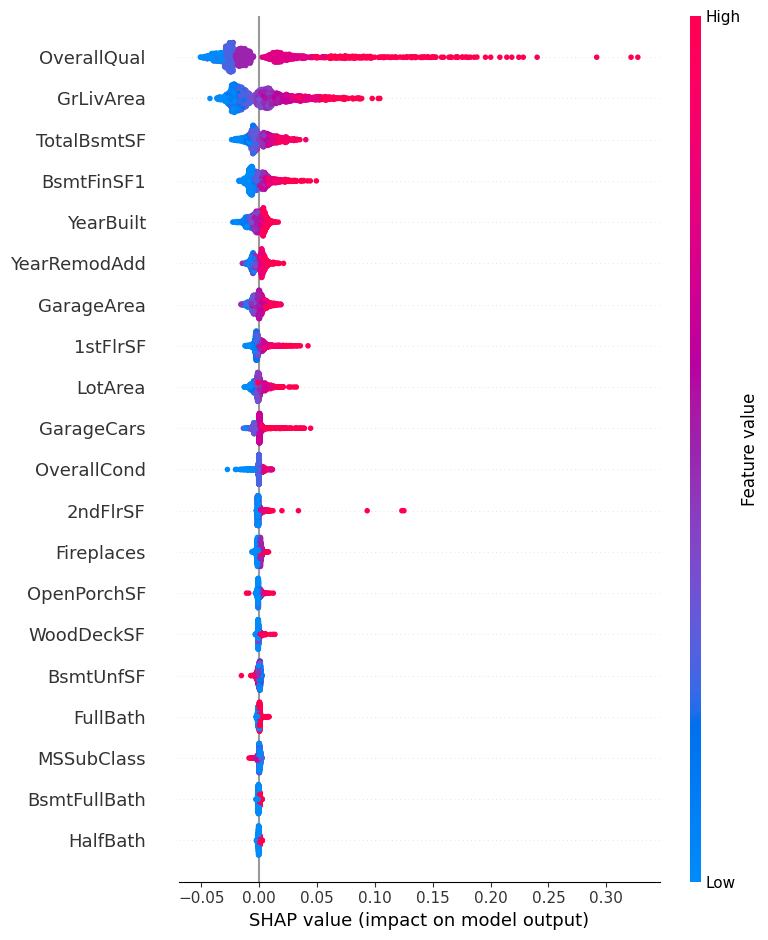

In [787]:
# Load the dataset
data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')


non_numerical_columns = data.select_dtypes(include=['object']).columns


# Perform numerical encoding for each non-numerical column
for column in non_numerical_columns:
    # Create a mapping of categories to numerical values
    category_mapping = {category: i for i, category in enumerate(data[column].unique())}

    # Map the categories to numerical values in the column
    data[column + '_encoded'] = data[column].map(category_mapping)

    # Drop the original non-numerical column
    data.drop(column, axis=1, inplace=True)


data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
data = data[feature_names]

#print(data.shape, data)

# Extract the features and target variable
X = data.drop('SalePrice', axis=1)  # Features
X = X.drop('Id', axis=1)  # Features
y = data['SalePrice']  # Target variable

feature_names = X.columns

y = y.values.reshape(-1, 1)

X = MinMaxScaler().fit_transform(X)

y = MinMaxScaler().fit_transform(y)

y = y.ravel()

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y
X_test = X
y_test = y

# Align the training and test data to ensure the same columns are present
#X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='outer', axis=1, fill_value=0)

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Fit model
reg = LinearRegression()
#reg = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg.predict(X_test)

# Example: Calculate root mean squared error (RMSE) on the test set
rmse_test = mean_squared_error(y_test, y_pred, squared=False)

# Convert y_test and y_pred to Pandas Series
y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')

# Concatenate actual and predicted values for display
results = pd.concat([y_test_series, y_pred_series], axis=1)
print(results)

print("RMSE (Test):", rmse_test)
print('score: ', reg.score(X_test, y_test))

# Create an explainer object using the trained model and training data
explainer = shap.Explainer(reg, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test, check_additivity=False)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


In [788]:

average_shap_values = np.abs(shap_values.values).mean(axis=0)
average_shap_values /= sum(average_shap_values)


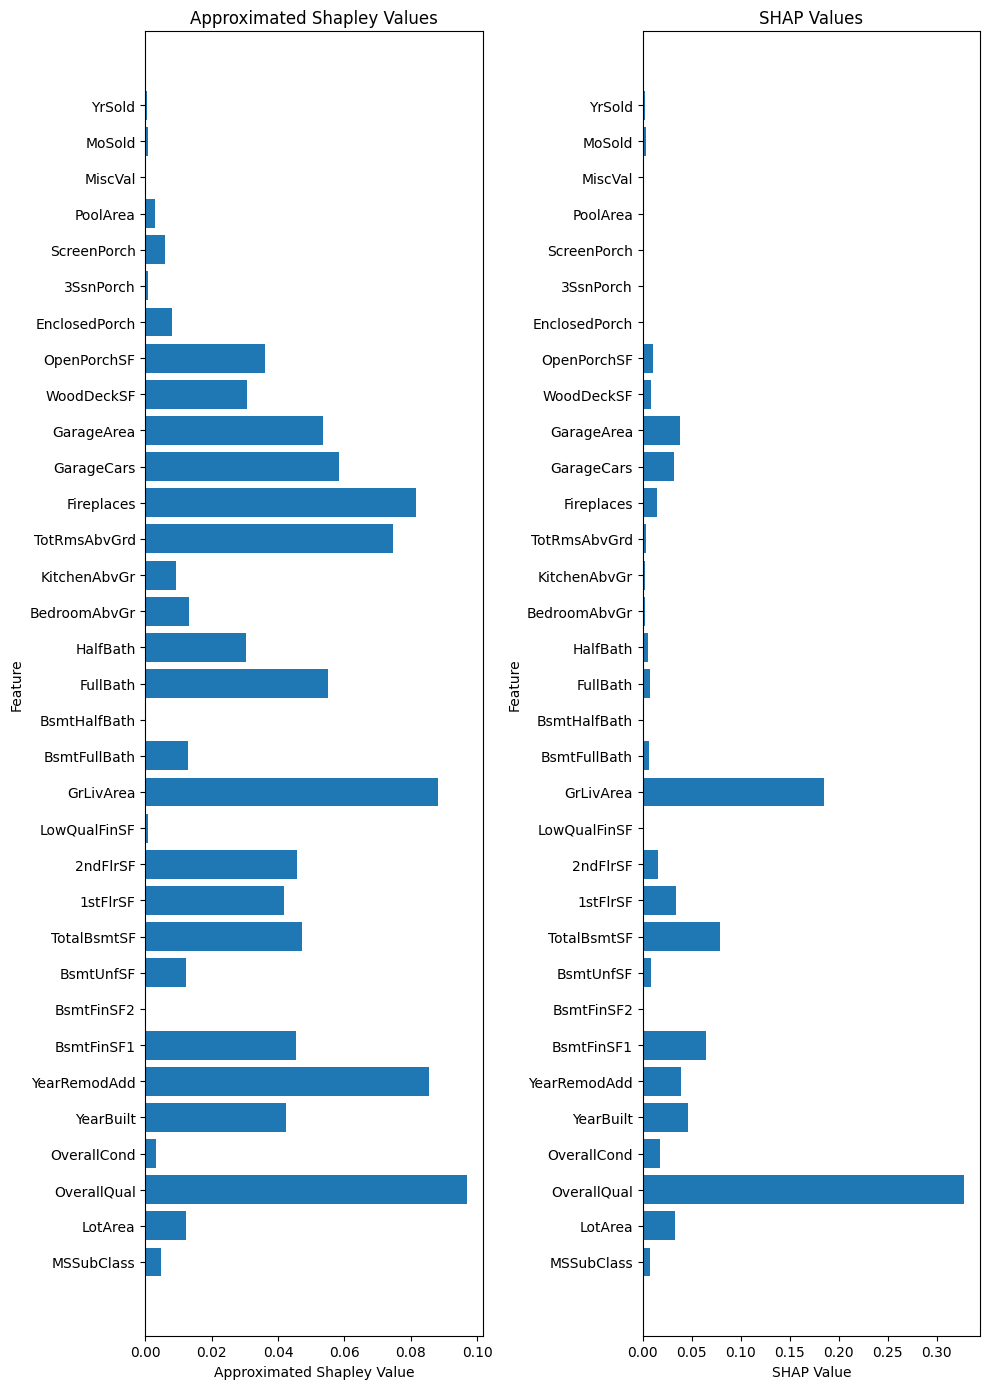

CPU times: user 47.1 s, sys: 18.2 s, total: 1min 5s
Wall time: 20.8 s


In [806]:
%%time
reg = LinearRegression()
#reg = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
#reg = RandomForestRegressor(n_estimators=100)
n = X_train.shape[1]
loops = 20
shap_reordered = np.zeros(X_train.shape[1])
for _ in range(loops):
    X2, y2, shap_knn = main_vfl(X_train, y_train, reg, n**(1/np.sqrt(n)),2)

    column_permutation = []
    for col in range(X_train.shape[1]):
        for col2 in range(X2.shape[1]):
            if np.array_equal(X_train[:, col], X2[:, col2]):
                column_permutation.append(col2)
                break

    shap_reordered += shap_knn[column_permutation]

#shap_reordered /= loops
shap_reordered /= sum(shap_reordered)

plt.figure(figsize=(10, 14))
# Plot the approximated Shapley values
plt.subplot(1, 2, 1)
plt.barh(feature_names, shap_reordered)
plt.xlabel("Approximated Shapley Value")
plt.ylabel("Feature")
plt.title("Approximated Shapley Values")

# Plot the SHAP values
plt.subplot(1, 2, 2)
plt.barh(feature_names, average_shap_values)
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.title("SHAP Values")

# Adjust the layout for better readability if needed
plt.tight_layout()

# Show the plot
plt.show()


[0.00503821 0.00135092 0.14827423 0.01187956 0.01996084 0.01321688
 0.06526516 0.04191932 0.00041355]
[0.00014055 0.05122547 0.00068246 0.00013921 0.00924909 0.00487534
 0.00346472 0.00032866]
[0.00727326 0.09341007 0.02120535 0.01242573 0.03055711 0.03174774
 0.00396212 0.03139018 0.03555493 0.03109728 0.0093685  0.00823377]
[0.10145943 0.01276522 0.00048662 0.00054309]


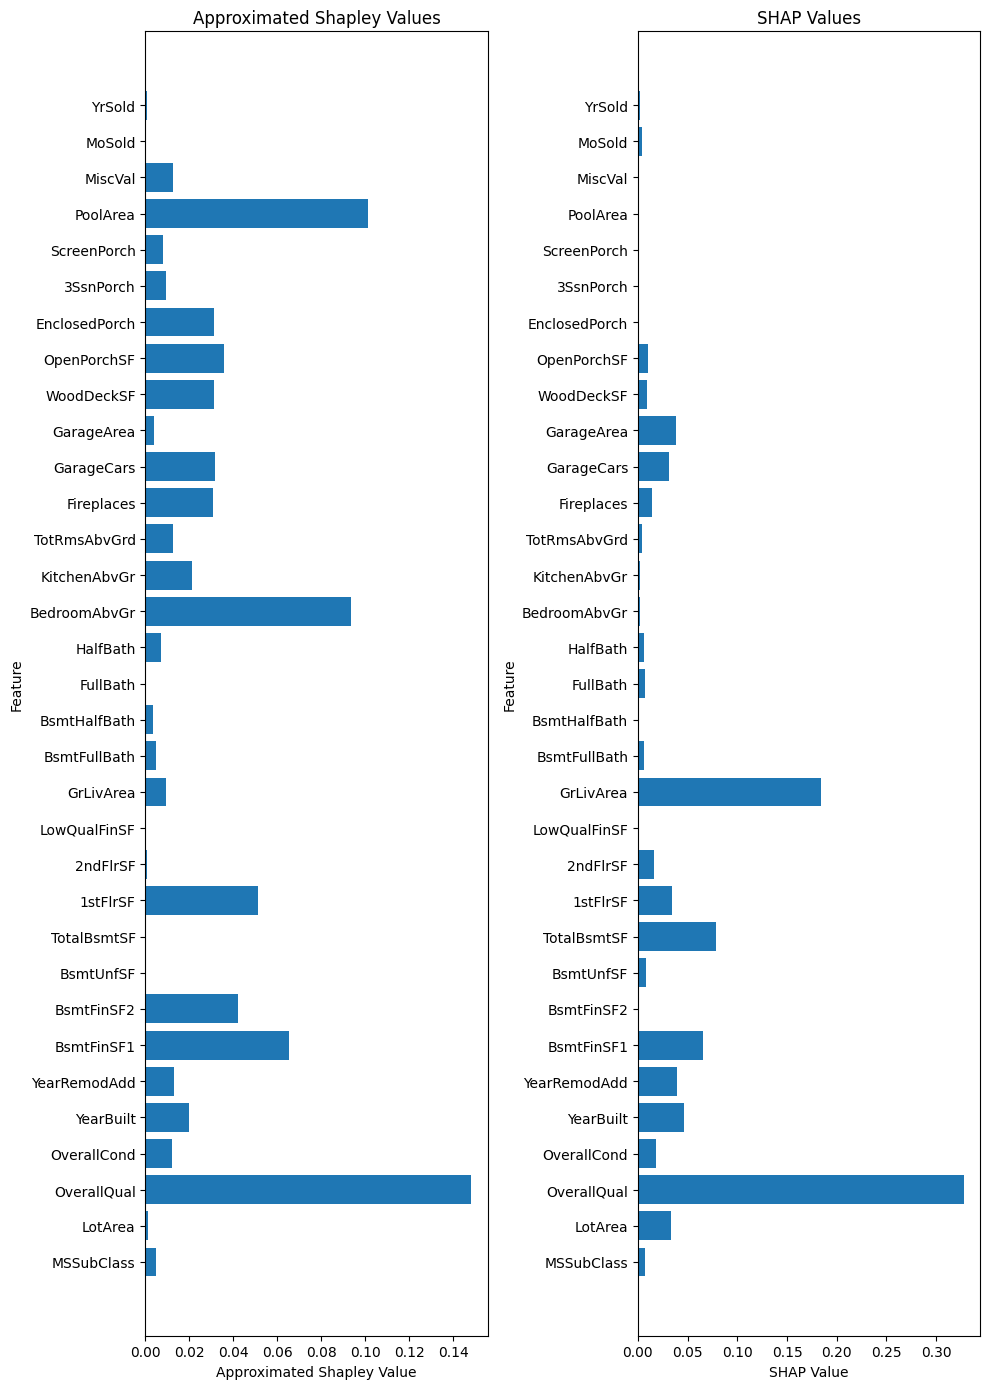

CPU times: user 1min 58s, sys: 25.7 s, total: 2min 24s
Wall time: 55.3 s


In [526]:
%%time
reg = LinearRegression()
#reg = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
#reg = RandomForestRegressor(n_estimators=100)
n = X_train.shape[1]
X2, y2, shap_knn = main_vfl(X_train, y_train, reg, n**(1/np.sqrt(n)),2)

plt.figure(figsize=(10, 14))  # Adjust the figure size as desired
# Plot the Shapley values

# Plot the approximated Shapley values
plt.subplot(1, 2, 1)
plt.barh(feature_names, shap_knn)
plt.xlabel("Approximated Shapley Value")
plt.ylabel("Feature")
plt.title("Approximated Shapley Values")

# Plot the SHAP values
plt.subplot(1, 2, 2)
plt.barh(feature_names, average_shap_values)
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.title("SHAP Values")

# Adjust the layout for better readability if needed
plt.tight_layout()

# Show the plot
plt.show()


In [882]:
print(sum(average_shap_values), sum(shap_knn))

0.9999999999999997 0.8089045698124414


In [883]:

#reg = LinearRegression()
#reg = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
#reg = RandomForestRegressor(n_estimators=100, random_state=42)
#reg = reg.fit(X_train, y)

y_pred = reg.predict(X_train)

# Example: Calculate root mean squared error (RMSE) on the test set
rmse_test = mean_squared_error(y, y_pred, squared=False)

# Convert y_test and y_pred to Pandas Series
y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')

# Concatenate actual and predicted values for display
results = pd.concat([y_test_series, y_pred_series], axis=1)
print(results)

print("RMSE (Test):", rmse_test)
print('score: ', reg.score(X_train, y))

        Actual  Predicted
0     0.241078   0.266944
1     0.203583   0.226540
2     0.261908   0.260135
3     0.145952   0.223417
4     0.298709   0.348904
...        ...        ...
1455  0.194556   0.211546
1456  0.243161   0.296784
1457  0.321622   0.273864
1458  0.148903   0.137436
1459  0.156367   0.173797

[1460 rows x 2 columns]
RMSE (Test): 0.048209927271992914
score:  0.8089045698124415


# VFL

In [873]:
class vfl_party:
    def __init__(self,data,k,p_id,cluster_means):
            self.data = data.transpose()
            #print(data.shape)
            self.k = k
            #initialize random mean values
            #kmeans = KMeans(n_clusters=k)
            #kmeans.fit(data)
            self.cluster_means = cluster_means
            #print(data)
            #print(self.mean_prime)
            self.p_id = p_id


    def iteration(self):
        dists = []
        for feature in self.data:
            dist = []
            for mean in self.cluster_means:
                #dist.append(distance.euclidean(feature, mean))
                dist.append(1 - cosine_similarity(feature.reshape(1, -1), mean.reshape(1, -1))[0][0])

            dists.append(dist)

        self.distances = dists

        #dists = np.array(dists)
        return dists

    def receive_new_means(self, cluster_means):

        prev_means = self.cluster_means
        self.cluster_means = cluster_means

        dist = 0
        for i in range(self.k):
            dist += distance.euclidean(prev_means[i],self.cluster_means[i])
        return dist

    def get_party_means(self, assignments):

        assignments = np.array(assignments)

        # Determine the cluster indices
        cluster_indices = np.unique(assignments)

        # Initialize an array to store the mean vectors
        mean_vectors = np.zeros((k, self.data.shape[1]))
        cluster_sizes = np.zeros(k)
        # Compute the mean vectors for each cluster
        for cluster_idx in range(k):
            cluster_vectors = self.data[assignments == cluster_idx]
            if len(cluster_vectors) > 0:
              mean_vectors[cluster_idx] = np.mean(cluster_vectors, axis=0)
              cluster_sizes[cluster_idx] = len(cluster_vectors)

        return mean_vectors, cluster_sizes


In [880]:

#df = pd.read_csv("./FIFA 2018 Statistics.csv")
#feature_names = [i for i in df.columns if df[i].dtype in [np.int64, np.int64]]
#X = df[feature_names]
#X = MinMaxScaler().fit_transform(X)
#y = (df['Man of the Match'] == "Yes")
#y = [1 if label == True else 0 for label in y]

num_parties = 4
n = X_train.shape[1] // num_parties  # Number of columns per party

k = 2
mean = np.random.rand(k, X_train.shape[0])

parties = []

# Split the data into parties
for i in range(num_parties):
    start_col = i * n
    end_col = (i + 1) * n if i < num_parties - 1 else X_train.shape[1]
    parties.append(vfl_party(X_train[:, start_col:end_col], k, i, mean))

In [881]:
#assume all data points are joint
X = X_train
threshold = 0.5
dist = 1000
while dist > threshold:
    #FOR EACH PARTY:
    #SET CURRENT MEAN TO LAST MEAN
    #SET ALL CLUSTES TO EMPTY
    #COMPUTE DISTANCE VECTORS FOR EACH POINT W.R.T CLUSTER MEANS
    #RETURN DISTANCES HERE
    #SEND DISTANCES TO PARTIES
    # ASSIGN POINTS TO CLUSTERS W.R.T TO OTHER PARTIES
    #SET MEAN PRIME TO MEAN OF NEW CLUSTERS
    #distances = []

    closest_clusters = []
    for p in parties:
        #distances.append(p.iteration())
        party_dist = p.iteration()
        closest_indices = []
        for feature in party_dist:
            closest_indices.append(np.argmin(feature))
        closest_clusters.append(closest_indices)


    print(closest_clusters)


    dist = 0
    mean_vectors = []
    cluster_sizes = []
    for p in parties:
        #p_dist = p.receive_cluster_assignemt(cluster_assignment)
        #dist+=p_dist
        party_mean_vectors, party_cluster_sizes = p.get_party_means(closest_clusters[p.p_id])
        mean_vectors.append(party_mean_vectors)
        cluster_sizes.append(party_cluster_sizes)
    #print(dist)

    # Convert data to NumPy arrays
    cluster_sizes = np.array(cluster_sizes)

    mean_vectors = np.array(mean_vectors)

    new_means = np.zeros((k, X.shape[0]))
    for cluster_idx in range(k):
        cluster_sum = np.zeros(X.shape[0])
        feature_count = 0
        for party_idx in range(len(parties)):
            cluster_sum += cluster_sizes[party_idx, cluster_idx] * mean_vectors[party_idx, cluster_idx]
            feature_count += cluster_sizes[party_idx, cluster_idx]

        if feature_count > 0:
            new_means[cluster_idx, :] = cluster_sum / feature_count
        #print(new_means)


    for p in parties:
        dist = p.receive_new_means(new_means)



[[0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 0, 0, 0]]


In [867]:
 def main_vfl(X, y, model, beta, k, num_loops = 1):
    X2, y2, shap = divisive_shap_approx_vfl(X, y, model, beta, 1, 1, k, num_loops)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)

def divisive_shap_approx_vfl(X, y, model, beta, gamma_n, gamma_d, k, num_loops):
    if X.shape[1] > max(np.emath.logn(beta, n), k):

        partitions = []
        sum_gamma_n = 0
        sum_gamma_d = 0
        for _ in range(num_loops):
            split_S = partition_cosine(X,y,k)
            partitions.append(split_S)
            sum_gamma_n += value(X, y, model)
            sum_gamma_d += sum([value(Xi, yi, model) for Xi, yi in split_S])
        gamma_n = gamma_n * (sum_gamma_n / num_loops)
        gamma_d = gamma_d * (sum_gamma_d / num_loops)
        return union([divisive_shap_approx_vfl(Xi,
                                               yi,
                                               model,
                                               beta,
                                               gamma_n,
                                               gamma_d,
                                               k,
                                               num_loops) for Xi, yi in split_S])

    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        #print(shap)
        return (X, y, shap)


def partition_cosine(X, y, k):

    X = X.T
    #similarities = cosine_similarity(X)

    # Initialize cluster assignments randomly
    #np.random.seed(42)
    labels = np.random.randint(low=0, high=k, size=len(X))

    # Iteratively update cluster assignments based on cosine similarity
    for _ in range(10):  # You can adjust the number of iterations as needed
        cluster_centers = []
        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                cluster_center = np.mean(cluster_points, axis=0)
                cluster_centers.append(cluster_center)
        cluster_centers = np.array(cluster_centers)

        # Assign each point to the nearest cluster center based on cosine similarity
        for i in range(len(X)):
            point = X[i]
            similarities_to_centers = cosine_similarity([point], cluster_centers)[0]
            new_label = np.argmax(similarities_to_centers)
            labels[i] = new_label

    partitions = []
    X = X.T
    X = pd.DataFrame(X)

    for i in range(k):
        partitions.append((np.array(X.iloc[:, labels == i]), y))

    return partitions


def value(X, y, model):
    if X.size == 0:
        return 0
    else:
        reg = model.fit(X, y)

        # Make predictions
        #y_pred = reg.predict(X)

        # Calculate RMSE
        #rmse = np.sqrt(mean_squared_error(y, y_pred))

        # Calculate the score between 0 and 1
        #score = 1 / rmse

        #print(reg.score(X, y))
        return reg.score(X, y)
        #print(score)
        #return score


def findsubsets(s, n):
    return list(itertools.combinations(s, n))

def shapley_true(X, y, model):
    """Returns true shapley value of each feature (numpy array)"""
    N = X.shape[1]
    shap = np.zeros(N)
    for i in range(N):
        other_features = set(range(N))
        other_features.remove(i)
        subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
        for subset in subsets:
            coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
            shap[i] += coeff*(value(X[:,list(subset) + [i]], y, model)-value(X[:, list(subset)], y, model))
    return np.array(shap)

def union(S_split):
    """Returns the union of several sets (Xi, Yi, Shapi)"""
    X = S_split[0][0]
    y = S_split[0][1]
    shap = S_split[0][2]
    for Xi, _, shapi in S_split[1:]:
        X = np.concatenate((X, Xi), axis=1)
        shap = np.concatenate((shap, shapi))
    return (X, y, shap)